# Example 3: SIR Model

In this example, apply DA methods applied to an SIR systems of ordinary differential equations. The SIR system is given by

\begin{align}
\dfrac{dS}{dt} &= - \beta SI, \quad S(0) = S_0, \\
\dfrac{dI}{dt} &= \beta SI - \lambda I, \quad I(0) = I_0, \\
\dfrac{dR}{dt} &= \lambda I, \quad R(0) = R_0,
\end{align}

where $S=S(t)$ are susceptibles,  $I=I(t)$ infected and  $R=R(t)$ recovered. The model parameters are  $\beta$  and $\lambda$  and the famous rate of reproduction is then

$$ R_0 = \frac{\beta}{\gamma} S_0 .$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
np.random.seed(7755)


def SIR(state, *args):
    """
    Parameters
    ----------
    state: array-like, shape (3,)
       Point of interest in three-dimensional space.
    *args: (sigma, lambda) : float
       Parameters defining the SIR dynamics.

    Returns
    -------
    state_dot : array, shape (3,)
       Values of the derivatives at *state*.
    """
    beta  = args[0]
    lambd = args[1]
    S, I, R = state # Unpack the state vector
    f = np.zeros(3)  # Derivatives
    f[0] = -beta*S*I
    f[1] =  beta*S*I - lambd*I
    f[2] =  lambd*I
    return f 

def RK4(rhs, state, dt, *args):
    
    k1 = rhs(state,         *args)
    k2 = rhs(state+k1*dt/2, *args)
    k3 = rhs(state+k2*dt/2, *args)
    k4 = rhs(state+k3*dt,   *args)

    new_state = state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
    return new_state

Text(0.5, 0, 't')

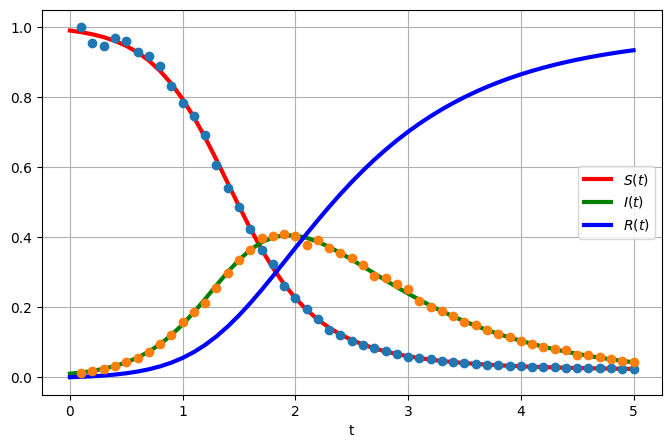

In [2]:
# parameters SIR
beta  = 4.0
lambd = 1.0
dt = 0.1
tm = 5
nt = int(tm/dt)
t  = np.linspace(0,tm,nt+1)
# initialize and solve
u0True = np.array([0.99, 0.01, 0]) # True initial conditions
#time integration
uTrue = np.zeros([nt+1,3])
uTrue[0,:] = u0True
for k in range(nt):
    uTrue[k+1,:] = RK4(SIR,uTrue[k,:], dt, beta, lambd)
# Observational model.  Lognormal likelihood.
yobs = np.random.lognormal(mean=np.log(uTrue[1::]), sigma=[0.02, 0.02, 0.])

# plot results
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,5))
ax.plot(t,uTrue[:,0], 'r', label='$S(t)$',  linewidth = 3)
ax.plot(t,uTrue[:,1], 'g', label='$I(t)$', linewidth = 3)
ax.plot(t,uTrue[:,2], 'b', label='$R(t)$', linewidth = 3)
ax.plot(t[1::], yobs[:,0:2], marker="o", linestyle="none")
ax.grid()
ax.legend()
ax.set_xlabel('t')

## Ensemble KF for Data Assimilation

Here we will generalize the ensemble Kalman filter to take into account the possibility of sparse observations. This is usually the case in real-life systems, where observations are only available et fixed instants, and hence the filtering can only be applied at these times. Inbetween observations, the system evolves freely (without correction) according to its underlying state equation.

Suppose we have $N_y$ measurements/observations at an interval of $\delta t_y.$ This gives measurements for times $t_0 \le t \le t_m,$ where $t_m = N_m \delta t_m.$ This can be considered as the assimilation window. The system then evolves freely for $t > t_m$ until some final forecast window time $t_f.$ The state, or equation itself is simulated with a smaller $\delta t$ and for a large number $N_t$ steps, giving $t_f = N_t \delta t.$ Usually, for real life systems, we will have

$$
  \delta t_m \ge \delta t,  \quad  N_m \le N_t , \quad t_m \le t_f.
$$

For code testing, we make the simplifying (unrealistic) academic assumption that

$$
  \delta t_m = \delta t, \quad N_m = N_t, \quad t_f = t_m.
$$

This implies the availabilty of measurements at each (and every) time step. Note that in many of the previous examples, this was indeed the case.

In [3]:
def enKF_SIR_setup(dt, T, dt_m, T_m, sig_w, sig_v): 
    """
    Prepare input (true state and observations) for the stochastic 
    ensemble filter of the Lorenz63 system.

    Parameters:
        dt: time step for state evolution
        T:  time interval for state evolution
        dt_m: time interval between 2 measurements (can equal dt for dense observations)
        T_m: time interval for observations
        sig_w: state noise sd., cov. Q = sig_w**2 x np.eye(3)
        sig_v: measurement noise sd., cov. R = sig_v**2 x np.eye(3) 
    """
    # parameters SIR
    beta  = 4.0
    lambd = 1.0
    dim_x = 3
    dim_y = 3
    # noise covariances
    Q  = sig_w**2 * np.eye(dim_x)
    R  = sig_v**2 * np.eye(dim_y)
    # measurement operator (identity here)
    def H(u):
        w = u
        return w

    # Solve system and generate noisy observations
    Nt = int(T/dt)     # number of time steps
    Nm = int(T_m/dt_m) # number of observations
    t = np.linspace(0, Nt, Nt+1) * dt # time vector
    ind_m = (np.linspace(int(dt_m/dt),int(T_m/dt),Nm)).astype(int) # obs. indices
    t_m = t[ind_m] # measurement time vector
    x0True = np.array([0.99, 0.01, 0]) # True initial conditions
    sqrt_Q = np.linalg.cholesky(Q) # noise std dev.
    sqrt_R = np.linalg.cholesky(R)
    # initialize (correctly!)
    xTrue = np.zeros([Nt+1, dim_x])
    xTrue[0, :] = x0True
    y = np.zeros((Nm, dim_y))
    km = 0 # index for measurement times
    y[0,:] = H(xTrue[0,:]) + sig_v * np.random.randn(dim_y) 
    for k in range(Nt):
        w_k = sqrt_Q @ np.random.randn(dim_x)
        xTrue[k+1,:] = RK4(SIR, xTrue[k,:], dt, beta, lambd) #+ w_k
        if (km < Nm) and (k+1 == ind_m[km]):
            v_k = sqrt_R @ np.random.randn(dim_y)
            y[km,:]     = H(xTrue[k+1,:]) + v_k
            km = km + 1
    # plot state and measurements
    fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(10,8))
    ax = ax.flat
    #t = T*dt
    for k in range(3):
        ax[k].plot(t,xTrue[:,k], label='True', linewidth = 3)
        ax[k].plot(t[ind_m],y[:,k], 'o', fillstyle='none', \
                   label='Observation', markersize = 8, markeredgewidth = 2)
        ax[k].set_xlabel('t')
        ax[k].axvspan(0, T_m, color='lightgray', alpha=0.4, lw=0)    
    ax[0].legend(loc="center", bbox_to_anchor=(0.5,1.25),ncol =4,fontsize=15)   
    ax[0].set_ylabel('S(t)')
    ax[1].set_ylabel('I(t)')
    ax[2].set_ylabel('R(t)')
    fig.subplots_adjust(hspace=0.5)

    return Q, R, xTrue, y, ind_m, Nt, Nm

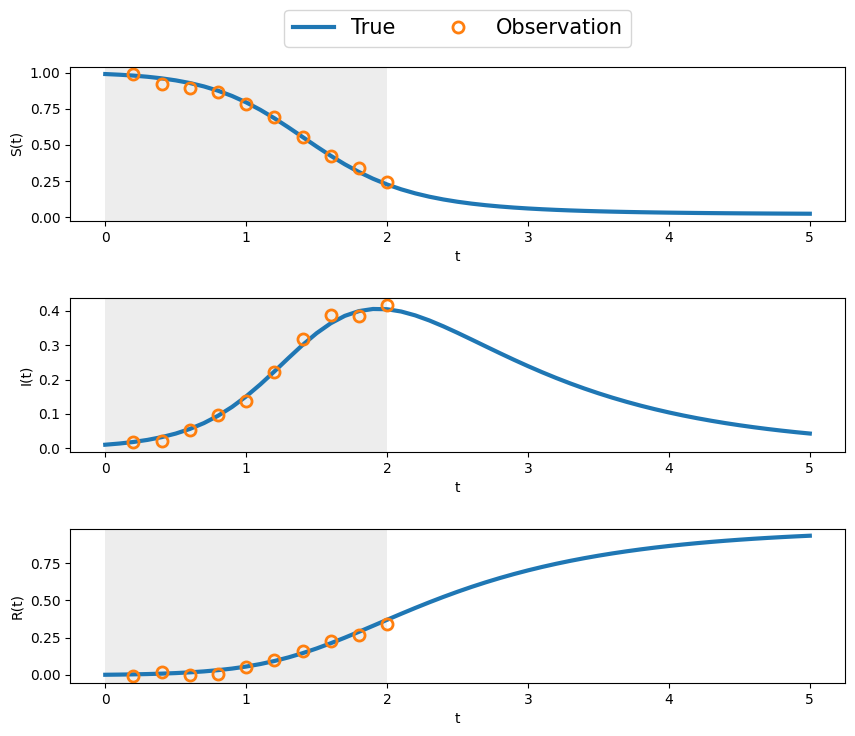

In [4]:
Q, R, xTrue, y, ind_m, Nt, Nm = enKF_SIR_setup(dt=0.1, T=5, dt_m=0.2, T_m =2, sig_w=0.001, sig_v=0.02)

In [5]:
def enKF_SIR_DA(x0, P0, Q, R, y, ind_m, Nt, Nm, Ne=10):
    """
    Run DA of the SIR system using the stochastic 
    ensemble filter with sparse observations in the DA
    window, defined by time index set `ind_m`.

    Parameters:
    
    """
    # parameters SIR
    beta  = 4.0
    lambd = 1.0
    def Hx(u):
        w = u
        return w
    Nx     = x0.shape[-1]
    Ny     = y.shape[-1]
    enkf_m = np.empty((Nt+1, Nx))
    enkf_P = np.empty((Nt+1, Nx, Nx))
    X      = np.empty((Nx, Ne))
    Xf     = np.empty((Nx, Ne))
    HXf    = np.empty((Ny, Nx))

    X[:,:] = np.tile(x0, (Ne,1)).T  + np.linalg.cholesky(P0)@np.random.randn(Nx, Ne) # initial ensemble state
    P       = P0 # initial state covariance
    enkf_m[0, :]    = x0 
    enkf_P[0, :, :] = P0

    i_m = 0 # index for measurement times
    
    for i in range(Nt):
        # ==== predict/forecast ====
        for e in range(Ne):
            w_i = np.linalg.cholesky(Q) @ np.random.randn(Nx)#, Ne)
            Xf[:,e] = RK4(SIR, X[:,e], dt,  beta, lambd) + w_i # predict state ensemble
        mX = np.mean(Xf, axis=1)        # state ensemble mean
        Xfp = Xf - mX[:, None]          # state forecast anomaly
        P = Xfp @ Xfp.T / (Ne - 1)      # predict covariance 
        # ==== prepare analysis step =====
        if (i_m < Nm) and (i+1 == ind_m[i_m]):
            HXf = Hx(Xf)              # nonlinear observation
            mY = np.mean(HXf, axis=1)       # observation ensemble mean
            HXp = HXf - mY[:, None]         # observation anomaly
            S = (HXp @ HXp.T)/(Ne - 1) + R  # observation covariance
            K = linalg.solve(S, HXp @ Xfp.T, assume_a="pos").T  / (Ne - 1)  # Kalman gain
            # === perturb y and compute innovation ====
            ypert = y[i_m, :] +  (np.linalg.cholesky(R)@np.random.randn(Ny, Ne)).T
            d = ypert.T - HXf
            # ==== correct/analyze ====
            X[:,:] = Xf + K @ d         # update state ensemble
            mX = np.mean(X[:,:], axis=1)# state analysis ensemble mean
            Xap = X[:,:] - mX[:, None]  # state analysis anomaly
            P = Xap @ Xap.T / ( Ne - 1)     # update covariance
            i_m = i_m + 1
        else:
            X[:,:] = Xf  # when there is no obs, then state=forecast
        # ==== save ====
        enkf_m[i+1] = mX                # save KF state estimate (mean)
        enkf_P[i+1] = P                 # save KF error estimate (covariance)
    return enkf_m, enkf_P

In [6]:
# Initialize and run the analysis
sig_w = 0.0015
sig_v = 0.02
Q  = sig_w**2 * np.eye(3) #* 1.e-6 # for comparison with DT
R  = sig_v**2 * np.eye(3)

x0 = np.array([0.95, 0.05, 0]) # a little off [0.99, 0.01, 0]
sig_vv = 0.1
P0 = np.eye(3) * sig_vv**2 # Initial estimate covariance
Ne = 10
Xa, P = enKF_SIR_DA(x0, P0, Q, R, y, ind_m, Nt, Nm, Ne=10)

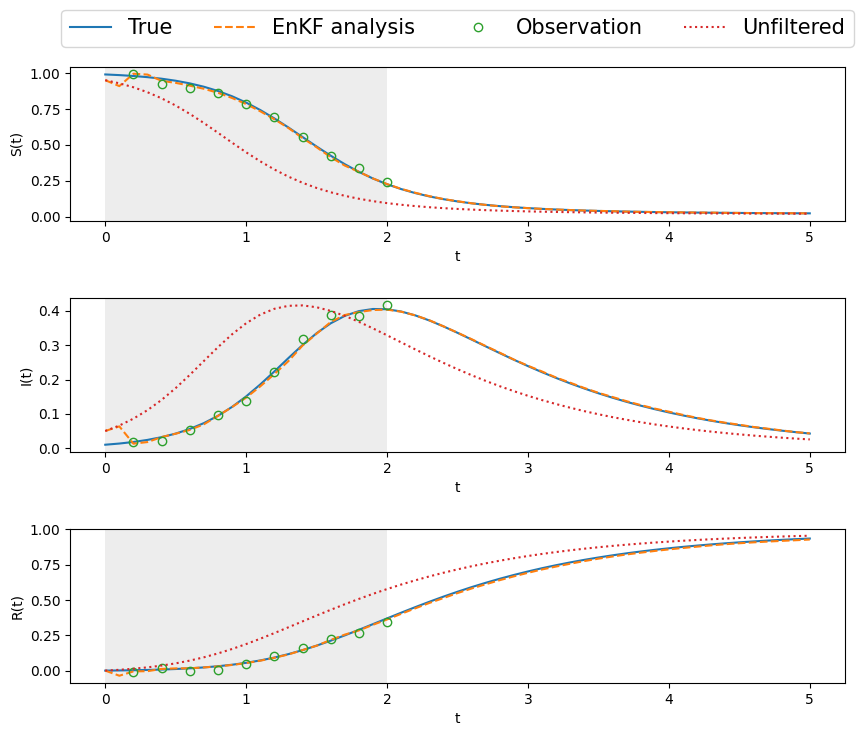

In [7]:
# Post-process and plot the results
# generate unfiltered state
Xb = np.empty((Nt+1, 3))
Xb[0,:] = x0
for i in range(Nt):
    Xb[i+1,:] =  RK4(SIR, Xb[i,:], dt, beta, lambd)    
# plot state and measurements
t = np.linspace(0, Nt, Nt+1) * dt # time vector
T_m = 2.
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(10,8))
ax = ax.flat

for k in range(3):
    ax[k].plot(t,xTrue[:,k], label='True')#, linewidth = 3)
    ax[k].plot(t,Xa[:,k], '--', label='EnKF analysis')#, linewidth = 3)
    ax[k].plot(t[ind_m],y[:,k], 'o', fillstyle='none', \
               label='Observation')#, markersize = 8, markeredgewidth = 2)
    ax[k].plot(t,Xb[:,k], ':', label='Unfiltered')#, linewidth = 3)
    ax[k].set_xlabel('t')
    ax[k].axvspan(0, T_m, color='lightgray', alpha=0.4, lw=0)    
ax[0].legend(loc="center", bbox_to_anchor=(0.5,1.25),ncol =4,fontsize=15)   
ax[0].set_ylabel('S(t)')
ax[1].set_ylabel('I(t)')
ax[2].set_ylabel('R(t)')
fig.subplots_adjust(hspace=0.5)

## Conclusion

The ensemble Kalman filter, even with sparse observations and a nonlinear system, does an excellent job of

1. tracking within the DA window
2. forecasting way beyond the window, whereas the unfiltered/unassimilated, freely evolving system deviates considerably, as is to be expected from the nonlinear SIR system.